In [2]:
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout

# Define data directories
train_dir = "training_data"
validation_dir = 'validation_data'
test_dir = 'test_data'

# Image data augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [3]:
# define how many samples the model will process during training and the height/width of input images
batch_size = 32
img_height = 150
img_width = 150


In [4]:
#ImageDataGenerator is used with flow_from_directory to generate batches of augmented images during training.
#This helps in handling large datasets that may not fit into memory.

# Image data generator for training set
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

# Image data generator for validation set
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

# Image data generator for test set
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

#The flow_from_directory method takes a directory containing images and organizes them into batches.
#These batches are then fed to the neural network for training, allowing the model to 
#learn from a subset of the data at a time, rather than the entire dataset all at once.

Found 2134 images belonging to 5 classes.
Found 1110 images belonging to 5 classes.
Found 600 images belonging to 5 classes.


In [ ]:
# Define the CNN model 9 layers
model = Sequential([
    # Convolutional layer with 32 filters, each of size (3, 3), and ReLU activation function.
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    
    # MaxPooling layer with pool size (2, 2), to down-sample the spatial dimensions.
    MaxPooling2D(2, 2),
    
    Dropout(0.25),
    
    # Convolutional layer with 64 filters, each of size (3, 3), and ReLU activation function.
    Conv2D(64, (3, 3), activation='relu'),
    
    # MaxPooling layer with pool size (2, 2).
    MaxPooling2D(2, 2),
    
    Dropout(0.25),
    
    # Convolutional layer with 128 filters, each of size (3, 3), and ReLU activation function.
    Conv2D(128, (3, 3), activation='relu'),
    
    # MaxPooling layer with pool size (2, 2).
    MaxPooling2D(2, 2),
    
        
    # Flatten layer to flatten the 3D output to 1D for fully connected layers.
    Flatten(),
    
    Dropout(0.25),
    
    # Fully connected Dense layer with 512 neurons and ReLU activation function.
    Dense(512, activation='relu'),
    
    # Output Dense layer with 5 neurons (one for each class) and softmax activation for multi-class classification.
    Dense(5, activation='softmax')  # 5 classes: bear, elephant, giraffe, lion, rhino
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #categorical crossentropy as there are multiple classes

# Train the model
history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=50, validation_data=validation_generator, validation_steps=len(validation_generator))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)


In [ ]:
model.save('PE02_animals_cnn_model2.h5')

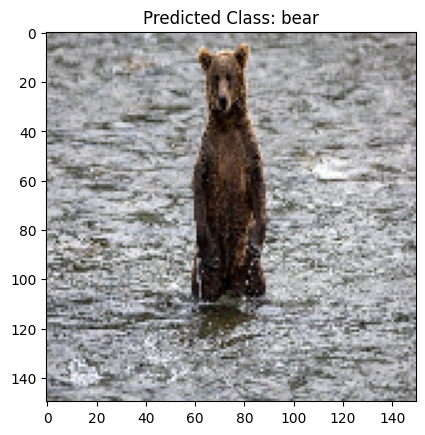

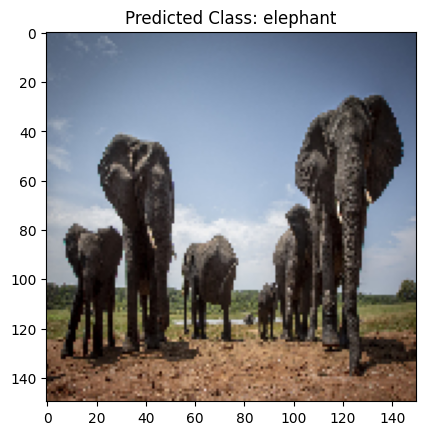

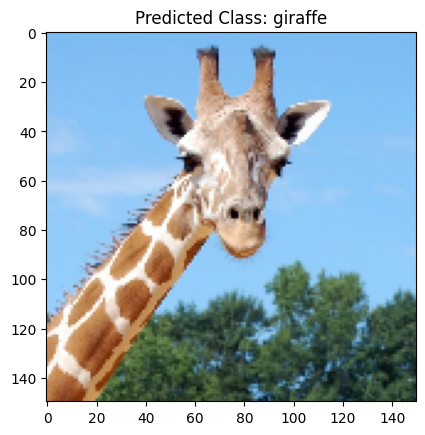

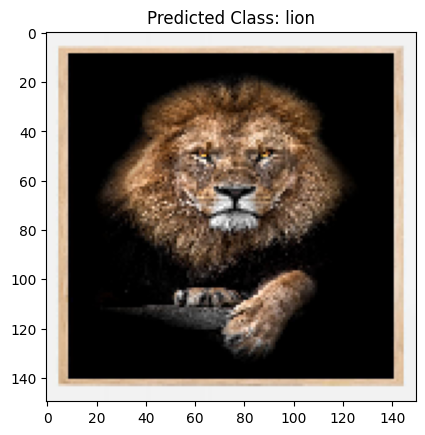

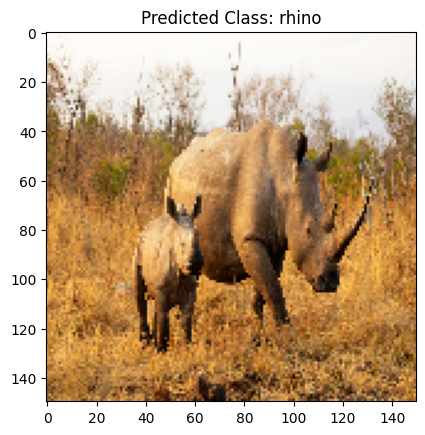

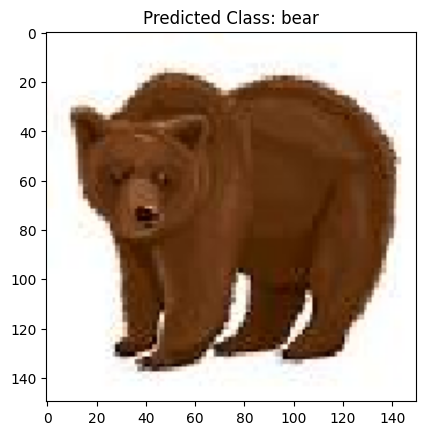

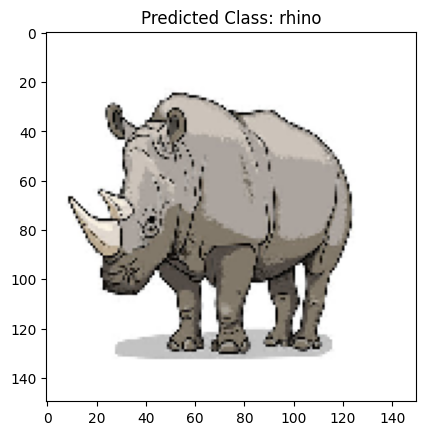

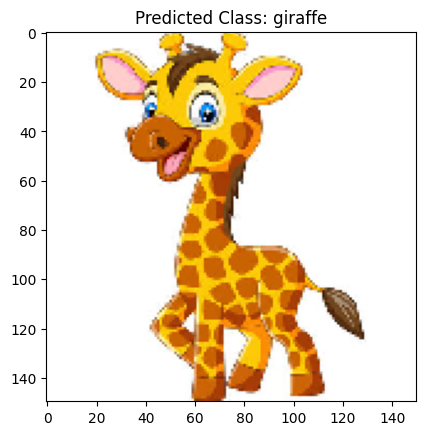

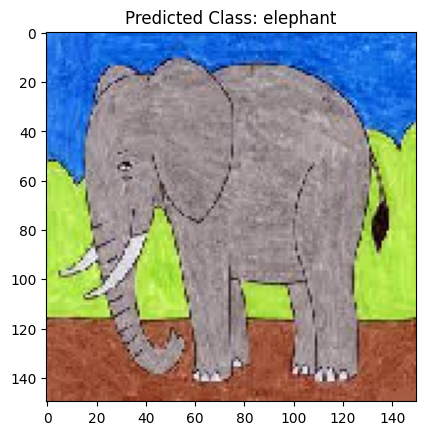

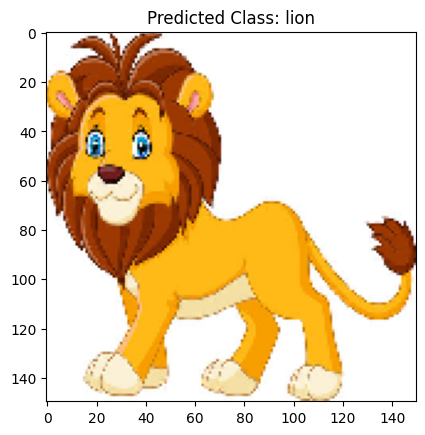

In [4]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
loaded_model = tf.keras.models.load_model('PE02_animals_cnn_model2.h5')
# Function to load and preprocess an image for testing
def preprocess_image(image_path, target_size=(150, 150)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to be in the range [0, 1]
    return img_array

# List of test image paths
test_image_paths = [
    'test_data/bear/00xp-bearsummer-1-kfjp-articleLarge.jpg',
    'test_data/elephant/1030620.jpg',
    'test_data/giraffe/1619447188-AVP-giraffe-2_desktop.jpg',
    'test_data/lion/1200x1200-Posters_2022_2_Focused_Lion_Color.jpg',
    'test_data/rhino/AdobeStock_456205385_420075_reduced.jpg',
    'test_data/bear/download (55).jpg',
    'test_data/rhino/rhino_cartoon.jpg',
    'test_data/giraffe/cartoon_giraffe.jpg',
    'test_data/elephant/download (50).jpg',
    'test_data/lion/cartoon_lion.jpg'
   
]

# Loop through test images
for test_image_path in test_image_paths:
    # Load and preprocess the test image
    img_array = preprocess_image(test_image_path)

    # Make predictions using the trained model
    predictions = loaded_model.predict(img_array)

    # Get the predicted class
    predicted_class = np.argmax(predictions)

    # Mapping index to class label
    class_labels = {0: 'bear', 1: 'elephant', 2: 'giraffe', 3: 'lion', 4: 'rhino'}
    predicted_label = class_labels[predicted_class]

    # Display the test image and predicted label
    img = image.load_img(test_image_path, target_size=(150, 150))
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_label}")
    plt.show()


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model to keep pre trained weights
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding custom layers on top of the pre-trained model
model_vgg16 = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile the model
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (use your existing data generators or adjust as needed)
history_vgg16 = model_vgg16.fit(train_generator, steps_per_epoch=len(train_generator), epochs=20,
                                validation_data=validation_generator, validation_steps=len(validation_generator))

# Evaluate the model
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(test_generator, steps=len(test_generator))
print('VGG16 Test accuracy:', test_acc_vgg16)


In [ ]:
# Loop through test images
for test_image_path in test_image_paths:
    # Load and preprocess the test image
    img_array = preprocess_image(test_image_path)

    # Make predictions using the trained model
    predictions = model_vgg16.predict(img_array)

    # Get the predicted class
    predicted_class = np.argmax(predictions)

    # Mapping index to class label
    class_labels = {0: 'bear', 1: 'elephant', 2: 'giraffe', 3: 'lion', 4: 'rhino'}
    predicted_label = class_labels[predicted_class]

    # Display the test image and predicted label
    img = image.load_img(test_image_path, target_size=(150, 150))
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_label}")
    plt.show()


In [ ]:
import io
import numpy as np
import tensorflow as tf
from PIL import Image
from flask import Flask, render_template, request
import base64
app = Flask(__name__, template_folder="PE02_2201843f_Part_B/template")

# Load the pre-trained model
loaded_model = tf.keras.models.load_model("PE02_animals_cnn_model2.h5")
expected_input_shape = loaded_model.layers[0].input_shape[1:4]  # Get (150, 150, 3)

def prepare_image(img):
    img = Image.open(io.BytesIO(img))
    img = img.convert("RGB")  # Ensure the image is in RGB mode
    img = img.resize((150, 150))  # Resize to model's expected input shape
    img = np.array(img)

    # Normalize the pixel values
    img = img / 255.0

    # Reshape the image into (1, height, width, channels)
    img = np.expand_dims(img, axis=0)

    return img




def predict_result(img):
    class_labels = {0: 'bear', 1: 'elephant', 2: 'giraffe', 3: 'lion', 4: 'rhino'}

    # Classify the image
    predictions = loaded_model.predict(img)

    return class_labels[np.argmax(predictions[0])]

@app.route('/', methods=['GET'])
def index():
    return render_template('PE02_2201843f_Part_B/template/submit_image.html')

@app.route('/predict', methods=['POST'])
def classify_image():
    if 'imagefile' not in request.files:
        return "Please try again. The Image doesn't exist"
    
    # Get the image file from request.files
    file = request.files.get("imagefile")

    if not file:
        return "Image not found"
    
    # Read image into bytes
    img_bytes = file.read()
    
    # Prepare image data
    img = prepare_image(img_bytes)
    
    # Classify the image data
    prediction_result = predict_result(img)
    
    # Convert image bytes into base64 string
    img_string = base64.b64encode(img_bytes).decode()

    # Add the predicted result as a parameter in render_template
    return render_template('PE02_2201843f_Part_B/template/submit_image.html', img_data=img_string, predict_data=prediction_result), 200

if __name__ == '__main__':
    from werkzeug.serving import run_simple
    app.debug = True    
    run_simple('localhost', 9000, app)

 * Running on http://localhost:9000
Press CTRL+C to quit
